# Stream, Run Sketches, Save to Influx

In [6]:
!pip install mmh3
!pip install pysad
!pip install combo

  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42865 sha256=b75aad2c906cf854076a979f95ccaf2be2016d83b7aecf570327bdb8f929724d
  Stored in directory: /home/jovyan/.cache/pip/wheels/38/1f/ca/644e141ce78ed0b75305118ce97ec7e2ed65c256dadedba561
Successfully built combo


In [44]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('./../SWaT_dataset_Jul 19 v2.xlsx', parse_dates = ['GMT +0'])

spark = SparkSession.builder.appName("Test").getOrCreate()
sdf = spark.createDataFrame(df) 
sdf.show(5)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


+--------------------+----------+----------+------+--------+-----------+-----------+----------+--------+----------+----------+--------+--------+--------+--------+-----+--------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------+----------+----------+----------+----------+----------+------+------+------+------+--------+-----------+-----------+-------+----------+-----------+----------+--------+--------+-----------+-----------+-----------+-----------+-----+----------+----------+----------+----------+-----------+-----------+-----------+----------+------+------+------+------+--------+-----------+-----------+----------+----------+----------+----------+-------+-------+--------+--------+--------+-------+--------+-----------+-----------+-----------+
|              GMT +0|   FIT 101|   LIT 101|MV 101|P1_STATE|P101 Status|P102 Status|   AIT 201| AIT 202|   AIT 203|   FIT 201|  LS 201|  LS 202| LSL 203|LSLL 203|MV201|P2_STATE|P201 Status|P202 S

## Flajolet-Martin Algorithm

In [3]:
print('Using Flajolet Martin Algorithm:')

def flajolet_martin(stream, name):
    maxnum=0
    for i in range(0,len(stream)):
        val= bin((1*stream[i] + 6) % 32)[2:]

        sum=0
        for j in range(len(val)-1,0,-1):

            if val[j]=='0':
                sum+=1
            else:
                break
        if sum>maxnum:
            maxnum=sum

    print('distict elements in ', name, ' are ', 2**maxnum)
    


Using Flajolet Martin Algorithm:


In [6]:
for k in ["FIT 401", "LIT 301"]:
    col = np.array(sdf.select(k).collect()).flatten().astype(int)
    # col = np.around(col)
    print(col)
    flajolet_martin(col, k)



[0 0 0 ... 0 0 0]
distict elements in  FIT 401  are  2
[883 883 883 ... 732 730 730]
distict elements in  LIT 301  are  16


## Frequency SpaceSaving

In [8]:
import math, heapq

class SpaceSavingCounter:
    def __init__(self, eps):
        self.k = math.ceil(1/eps)
        self.n = 0
        self.counts = dict()
        self.queue = []

    def inc(self, x):
        # increment total elements seen
        self.n += 1

        # x is being watched
        if x in self.counts:
            self.counts[x] += 1

        # x is not being watched
        else:
            # make room for x
            if self.n > self.k:
                while True:
                    count, tstamp, key = self.pop()
                    assert self.counts[key] >= count
                    if self.counts[key] == count:
                        del self.counts[key]
                        break
                    else:
                        self.push(self.counts[key], tstamp, key)
            else:
                count = 0

            # watch x
            self.counts[x] = count + 1
            self.push(count, self.n, x)


    def push(self, count, tstamp, key):
        heapq.heappush(
            self.queue,
            (count, tstamp, key)
        )

    def pop(self):
        return heapq.heappop(self.queue)

In [9]:
for k in ["P601 Status","MV201", "P101 Status", "MV 501", "P301 Status"]:
    stream = np.array(sdf.select(k).collect()).flatten()
    # col = np.around(col)
    # print(col)
    # flajolet_martin(col, k)
    for x in stream:
        counter.inc(x)
    print(k,counter.counts)

P601 Status {1: 14996}
MV201 {2: 29992}
P101 Status {2: 44988}
MV 501 {2: 59984}
P301 Status {1: 74980}


## Real Time Anomaly Detection with Histogram-based Outlier Score (HBOS)

In [103]:
from pysad.evaluation.metrics import AUROCMetric
from pysad.models.loda import LODA
from pysad.utils.data import Data
from pysad.models.integrations import ReferenceWindowModel
from pyod.models.hbos import HBOS
from pysad.transform.postprocessing import RunningAveragePostprocessor
from pysad.transform.preprocessing import InstanceUnitNormScaler
from pysad.transform.probability_calibration import GaussianTailProbabilityCalibrator

In [104]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

token = 'Qd6R1JJWOOKfcKmBn0s50wHLqA-2LjLjEGJiUAGp1_RCes_JRe_bkELLYL5jqCXRQ1Haww3_mrHk_69yN88L0A=='
org = 'ELTE'
bucket = 'ELTE'

# Define the model
model = LODA()

with influxdb_client.InfluxDBClient(url="http://influxdb:8086", token=token, org=org) as client:
    write_api = client.write_api(write_options=SYNCHRONOUS)
    stream = np.array(sdf.select("LIT 301", "FIT 401").collect())
    model = ReferenceWindowModel(model_cls=HBOS,  window_size=500, sliding_size=200,)
    preprocessor = InstanceUnitNormScaler()  # Normalizer
    postprocessor = RunningAveragePostprocessor(window_size=100)  # Running average postprocessor
    calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)
    y_pred = []
    for x in stream:
        X = preprocessor.fit_transform_partial(x)
        anomaly_score = model.fit_score_partial(x)
        anomaly_score = postprocessor.fit_transform_partial(anomaly_score)
        calibrated_score = calibrator.fit_transform_partial(anomaly_score)
        p = influxdb_client.Point("test_3").field("Anomaly Score", calibrated_score)
        write_api.write(bucket, org, p) 

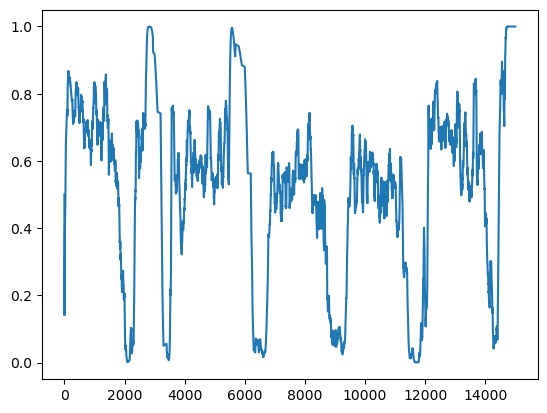

In [99]:
# stream = np.array(sdf.select("LIT 301", "FIT 401").collect())
# model = ReferenceWindowModel(model_cls=HBOS,  window_size=500, sliding_size=200,)
# preprocessor = InstanceUnitNormScaler()  # Normalizer
# postprocessor = RunningAveragePostprocessor(window_size=100)  # Running average postprocessor
# calibrator = GaussianTailProbabilityCalibrator(running_statistics=True, window_size=6400)

# y_pred = []
# for x in stream:
#     X = preprocessor.fit_transform_partial(x)
#     anomaly_score = model.fit_score_partial(x)
#     anomaly_score = postprocessor.fit_transform_partial(anomaly_score)
#     calibrated_score = calibrator.fit_transform_partial(anomaly_score)
#     y_pred.append(calibrated_score)
#     # anomaly_score.append(model.fit_score_partial(x))
# plt.plot(y_pred)
# plt.show()

## Saving All Attacked Columns 

In [12]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

token = 'Qd6R1JJWOOKfcKmBn0s50wHLqA-2LjLjEGJiUAGp1_RCes_JRe_bkELLYL5jqCXRQ1Haww3_mrHk_69yN88L0A=='
org = 'ELTE'
bucket = 'ELTE'

cols_with_attackes = ["FIT 401", "LIT 301", "P601 Status","MV201", "P101 Status", "MV 501", "P301 Status"]

with influxdb_client.InfluxDBClient(url="http://influxdb:8086", token=token, org=org) as client:
    write_api = client.write_api(write_options=SYNCHRONOUS)
    dataCollect = sdf.collect()
    for row in dataCollect:
        for col in cols_with_attackes:
            p = influxdb_client.Point("swat_attacked_cols").field(col, row[col])
            write_api.write(bucket, org, p)    

In [10]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [11]:
df['AIT 202']

0        9.313829
1        9.316713
2        9.317354
3        9.317354
4        9.319918
           ...   
14991    9.289157
14992    9.289157
14993    9.293002
14994    9.293002
14995    9.293002
Name: AIT 202, Length: 14996, dtype: float64

In [12]:
min_max = MinMaxScaler()
df_scaled = pd.DataFrame(min_max.fit_transform(df[["FIT 401", "LIT 301"]]), columns=["FIT_401_scaled", "LIT_301_scaled"])
df_scaled['FIT 401'] = df['FIT 401']
df_scaled['LIT 301'] = df['LIT 301']

df_scaled['P601 Status'] = df['P601 Status']
df_scaled['MV201'] = df['MV201']
df_scaled['P101 Status'] = df['P101 Status']
df_scaled['MV 501'] = df['MV 501']
df_scaled['3101 Status'] = df['P301 Status']

df_scaled.head()

,FIT_401_scaled,LIT_301_scaled,FIT 401,LIT 301,P601 Status,MV201,P101 Status,MV 501,3101 Status
0,0.970514,0.400985,0.807990,883.908000,1,2,2,2,2
1,0.972312,0.400985,0.808631,883.908000,1,2,2,2,2
2,0.974110,0.399622,0.809271,883.387268,1,2,2,2,2
3,0.974110,0.399203,0.809271,883.227051,1,2,2,2,2
4,0.974110,0.399203,0.809271,883.227051,1,2,2,2,2


In [14]:
df_scaled.columns

Index(['FIT_401_scaled', 'LIT_301_scaled', 'FIT 401', 'LIT 301', 'P601 Status',
       'MV201', 'P101 Status', 'MV 501', '3101 Status'],
      dtype='object')

In [15]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

token = 'Qd6R1JJWOOKfcKmBn0s50wHLqA-2LjLjEGJiUAGp1_RCes_JRe_bkELLYL5jqCXRQ1Haww3_mrHk_69yN88L0A=='
org = 'ELTE'
bucket = 'ELTE'

cols_saved = df_scaled.columns
sdf_scaled = spark.createDataFrame(df_scaled) 

with influxdb_client.InfluxDBClient(url="http://influxdb:8086", token=token, org=org) as client:
    write_api = client.write_api(write_options=SYNCHRONOUS)
    dataCollect = sdf_scaled.collect()
    for row in dataCollect:
        for col in cols_saved:
            p = influxdb_client.Point("swat_dashboard_1").field(col, row[col])
            write_api.write(bucket, org, p)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
